# 04.1 Black–Scholes Model and Risk-Neutral Measure
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**
- Introduce the continuous-time Black–Scholes market with a risk-free asset and a risky asset following geometric Brownian motion (GBM).
- Formalise self-financing trading strategies and discounted wealth.
- Construct the risk-neutral measure via a simple Girsanov change of measure.
- Show that the discounted stock price is a martingale under the risk-neutral measure.
- Illustrate the dynamics by Monte Carlo simulation under both the physical and risk-neutral measures.

**This notebook**

Builds the probabilistic backbone of the Black–Scholes world: the market model, the risk-neutral probability, and the martingale property of discounted prices. Later notebooks will plug option payoffs into this structure to obtain pricing formulas and hedging strategies.

# 1. Black–Scholes market model

We work on a filtered probability space $(\Omega, \mathcal{F}, (\mathcal{F}_t)_{t \geq 0}, \mathbb{P})$ supporting a standard Brownian motion $(B_t)_{t \geq 0}$.

The Black–Scholes market consists of:

- a risk-free asset (money market account) $S_t^0$,
- a risky asset (stock) $S_t$.

The dynamics are

$$
\begin{cases}
dS_t^0 = r S_t^0 \, dt, & S_0^0 = 1, \\
dS_t = S_t (\mu \, dt + \sigma \, dB_t), & S_0 > 0,
\end{cases}
$$

where

- $r$ is the constant risk-free rate,
- $\mu$ is the (physical) drift of the stock,
- $\sigma > 0$ is the volatility,
- $B_t$ is a standard Brownian motion under $\mathbb{P}$.

Solving the ODE for $S_t^0$ gives

$$
S_t^0 = e^{rt}.
$$

For the stock, this is exactly the GBM SDE studied previously. The unique strong solution is

$$
S_t = S_0 \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma B_t\right).
$$

Thus $\ln S_t$ is Gaussian and $S_t$ is lognormal:

$$
\ln S_t \sim \mathcal{N}\left(\ln S_0 + \left(\mu - \frac{1}{2}\sigma^2\right)t, \, \sigma^2 t\right).
$$


## 1.1 Quick simulation of GBM paths under $\mathbb{P}$

We simulate a few GBM paths under the physical measure $\mathbb{P}$ to visualise the model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings

rng = np.random.default_rng(123)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

warnings.filterwarnings("ignore", category=SyntaxWarning)

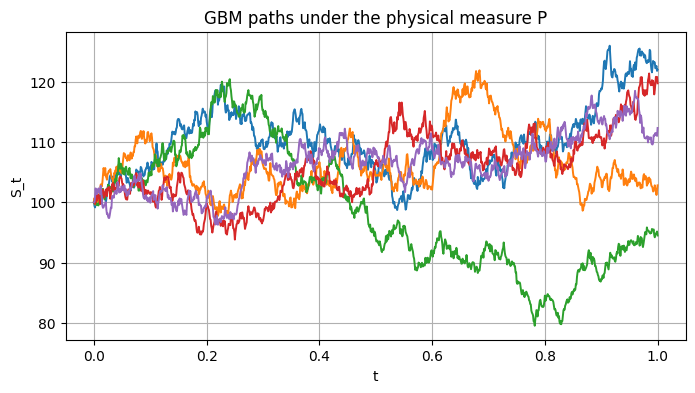

In [2]:
def simulate_gbm_paths(S0, mu, sigma, T, n_steps, n_paths, rng):
    dt = T / n_steps
    t_grid = np.linspace(0, T, n_steps + 1)
    dW = rng.normal(0.0, np.sqrt(dt), size=(n_paths, n_steps))
    W = np.concatenate([np.zeros((n_paths, 1)), np.cumsum(dW, axis=1)], axis=1)
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t_grid + sigma * W)
    return t_grid, S

S0 = 100.0
mu = 0.08
sigma = 0.2
T = 1.0
n_steps = 1000
n_paths = 5

t, S_P = simulate_gbm_paths(S0, mu, sigma, T, n_steps, n_paths, rng)

for i in range(n_paths):
    plt.plot(t, S_P[i], lw=1.4)
plt.title("GBM paths under the physical measure P")
plt.xlabel("t")
plt.ylabel("S_t")
plt.show()

# 2. Self-financing strategies and discounted wealth

A trading strategy is a pair of adapted processes $(H_t^0, H_t)_{t \geq 0}$:

- $H_t^0$: number of units in the risk-free asset,
- $H_t$: number of units in the stock.

The associated wealth process is

$$V_t = H_t^0 S_t^0 + H_t S_t.$$

The strategy is self-financing if changes in $V_t$ come only from price changes, not from external cash flows:

$$dV_t = H_t^0 \, dS_t^0 + H_t \, dS_t.$$

We now work in discounted units to remove the deterministic growth at rate $r$.

Define the discounted processes

$$\tilde{S}_t = e^{-rt} S_t, \quad \tilde{V}_t = e^{-rt} V_t.$$

Using Itô's formula and the self-financing condition, one obtains

$$d\tilde{V}_t = H_t \, d\tilde{S}_t, \quad \tilde{V}_t = V_0 + \int_0^t H_u \, d\tilde{S}_u.$$

This expression has two important consequences:

- discounted wealth is obtained by integrating the discounted stock price against the trading strategy,
- once in discounted form, the risk-free asset disappears from the dynamics.


# 3. Simulation under $\mathbb{P}$ vs $\mathbb{P}^*$

Under $\mathbb{P}$:

$$S_t = S_0 \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma B_t\right),$$

Under $\mathbb{P}^*$:

$$S_t^* = S_0 \exp\left(\left(r - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right).$$

The volatility is the same; only the drift changes from $\mu$ to $r$.

We now simulate GBM paths under the physical measure $\mathbb{P}$ and the risk-neutral measure $\mathbb{P}^*$. We expect the two sets of trajectories to look almost identical because they share the same Brownian shocks; the only visible difference should be a small level shift caused by the change in drift (from $\mu$ to $r$).


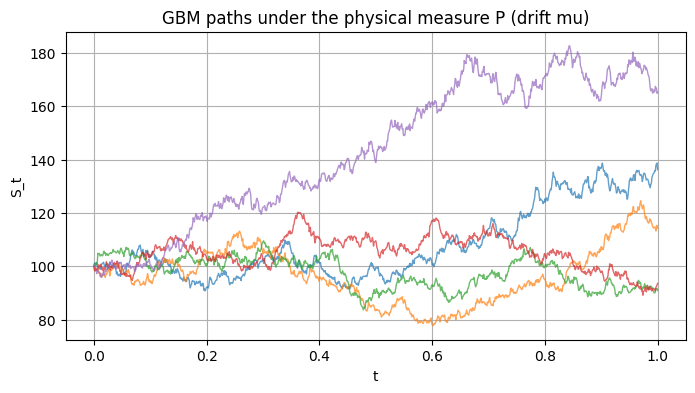

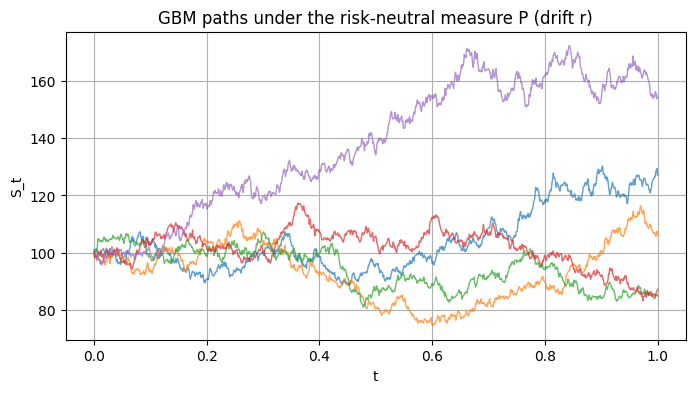

In [3]:
def simulate_gbm_physical_and_rn(S0, mu, r, sigma, T, n_steps, n_paths, rng):
    dt = T / n_steps
    t_grid = np.linspace(0, T, n_steps + 1)

    # Brownian motion under P
    dB = rng.normal(0.0, np.sqrt(dt), size=(n_paths, n_steps))
    B = np.concatenate([np.zeros((n_paths, 1)), np.cumsum(dB, axis=1)], axis=1)

    # Brownian motion under P*: same dW, but different drift inside the exponent
    # Easier: reuse B, but change the drift in the exponent.
    S_P  = S0 * np.exp((mu - 0.5*sigma**2)*t_grid + sigma*B)
    S_RN = S0 * np.exp((r   - 0.5*sigma**2)*t_grid + sigma*B)

    return t_grid, S_P, S_RN

S0 = 100.0
mu = 0.10
r = 0.03
sigma = 0.25
T = 1.0
n_steps = 1000
n_paths = 5

t, S_P, S_RN = simulate_gbm_physical_and_rn(S0, mu, r, sigma, T, n_steps, n_paths, rng)

plt.plot(t, S_P.T, lw=1.0, alpha=0.7)
plt.title("GBM paths under the physical measure P (drift mu)")
plt.xlabel("t")
plt.ylabel("S_t")
plt.show()

plt.plot(t, S_RN.T, lw=1.0, alpha=0.7)
plt.title("GBM paths under the risk-neutral measure P (drift r)")
plt.xlabel("t")
plt.ylabel("S_t")
plt.show()


In [36]:
print("max |S_P - S_RN| =", np.max(np.abs(S_P - S_RN)))

max |S_P - S_RN| = 9.972097810092436


The two plots look almost identical because they use the same Brownian shocks, so they share the same random fluctuations. The only difference is the drift (μ vs r), which creates a small level shift, numerically visible (max |S_P − S_RN| ≈ 9.97) but visually hard to detect over a 1-year horizon

# 4. Discounted stock as a martingale under $\mathbb{P}^*$

Under the risk-neutral dynamics

$$d\tilde{S}_t = \sigma \tilde{S}_t \, dW_t,$$

the SDE has no drift term.
From the Itô integral properties, this implies that $\tilde{S}_t$ is a martingale:

$$\mathbb{E}^*[\tilde{S}_t \mid \mathcal{F}_s] = \tilde{S}_s, \quad 0 \leq s \leq t.$$

We now check this numerically on simulated paths.


## 4.1 Monte Carlo check of the martingale property

We simulate many GBM paths under $\mathbb{P}^*$, compute $\tilde{S}_t = e^{-rt} S_t$, and look at the empirical mean as a function of time.


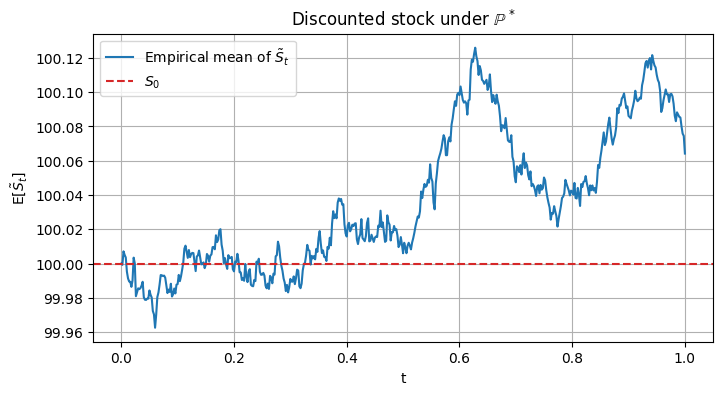

Mean at t=0: 100.0000
Mean at t=T: 100.0642


In [4]:
def simulate_gbm_rn(S0, r, sigma, T, n_steps, n_paths, rng):
    dt = T / n_steps
    t_grid = np.linspace(0, T, n_steps + 1)
    dW = rng.normal(0.0, np.sqrt(dt), size=(n_paths, n_steps))
    W = np.concatenate([np.zeros((n_paths, 1)), np.cumsum(dW, axis=1)], axis=1)
    S = S0 * np.exp((r - 0.5*sigma**2)*t_grid + sigma*W)
    return t_grid, S

S0 = 100.0
r = 0.03
sigma = 0.25
T = 1.0
n_steps = 500
n_paths = 50_000

t, S_RN_many = simulate_gbm_rn(S0, r, sigma, T, n_steps, n_paths, rng)
S_disc = np.exp(-r * t) * S_RN_many  # discounted stock

mean_disc = S_disc.mean(axis=0)

plt.plot(t, mean_disc, label="Empirical mean of $\~S_t$")
plt.axhline(S0, color="tab:red", ls="--", label="$S_0$")
plt.title("Discounted stock under $\mathbb{P}^*$")
plt.xlabel("t")
plt.ylabel("E$[\~S_t]$")
plt.legend()
plt.show()

print(f"Mean at t=0: {mean_disc[0]:.4f}")
print(f"Mean at t=T: {mean_disc[-1]:.4f}")


The empirical mean $\mathbb{E}[\tilde{S}_t]$ remains approximately constant and equal to $S_0$, confirming numerically that the discounted stock is a martingale under $\mathbb{P}^*$.


## 4.2 Distribution of $S_T$ under $\mathbb{P}$ vs $\mathbb{P}^*$

Finally, we compare the marginal distributions of $S_T$ under the two measures.


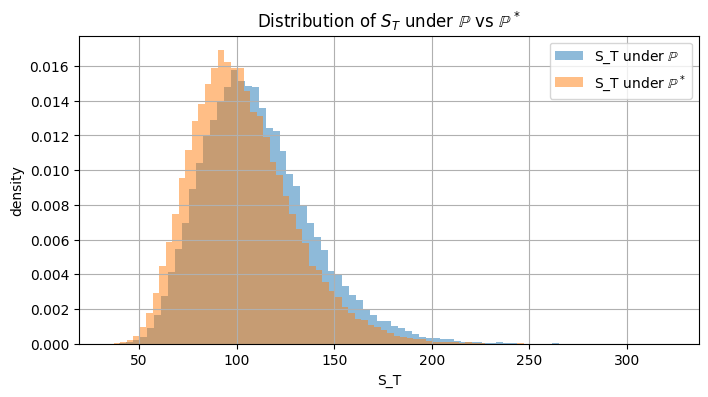

Empirical E_P[S_T]   ≈ 110.63
Empirical E_P*[S_T]  ≈ 103.15
Theoretical E_P*[S_T]= 103.05


In [5]:
S0 = 100.0
mu = 0.10
r = 0.03
sigma = 0.25
T = 1.0
n_steps = 500
n_paths = 50_000

t, S_P_many, S_RN_many = simulate_gbm_physical_and_rn(S0, mu, r, sigma, T, n_steps, n_paths, rng)

S_P_T  = S_P_many[:, -1]
S_RN_T = S_RN_many[:, -1]

plt.hist(S_P_T, bins=80, density=True, alpha=0.5, label="S_T under $\mathbb{P}$")
plt.hist(S_RN_T, bins=80, density=True, alpha=0.5, label="S_T under $\mathbb{P}^*$")

plt.title("Distribution of $S_T$ under $\mathbb{P}$ vs $\mathbb{P}^*$")
plt.xlabel("S_T")
plt.ylabel("density")
plt.legend()
plt.show()

print(f"Empirical E_P[S_T]   ≈ {S_P_T.mean():.2f}")
print(f"Empirical E_P*[S_T]  ≈ {S_RN_T.mean():.2f}")
print(f"Theoretical E_P*[S_T]= {S0*np.exp(r*T):.2f}")

The two distributions have identical volatility and shape, but differ in their mean: under the physical measure $\mathbb{P}$, the empirical mean is $\mathbb{E}_{\mathbb{P}}[S_T] \approx 110.63$, consistent with growth at the real drift $\mu$. Under the risk-neutral measure $\mathbb{P}^*$, the mean drops to $\mathbb{E}_{\mathbb{P}^*}[S_T] \approx 103.05$, matching the theoretical value $103.15$ implied by growth at the risk-free rate $r$. The only difference is this shift in the mean, the randomness (Brownian shocks) is identical in both cases.
